# *`BISTRO`* Starter-Kit Simulation Tutorial

**v2.0 ----------------------------------------------------**

*updated 04/24/2020*
- updated the latest docker image,
- modified script files for visualization.

## Table of Content:
* [Parameters and path: the `competition_executor.py` module](#first-bullet)
* [Running a simulation: `EXECUTOR.run_simulation()`](#second-bullet)
* [Simulation log: Docker](#third-bullet)
* [Simulation results: submissionScores.csv](#fourth)
* [The `input_sampler` module:](#last-bullet)

To simplify interaction with the Docker-based simulation execution and evaluation, we've provided a set of Python utilities (located in the `/utilities` folder of the Starter-Kit repository). This notebook demonstrates how they may be used to accomplish the following tasks:

1. Starting a rudimentary simulation or several simulations with speficied submission_inputs
2. Specify simulation running resources/senarios/sample size/number of iterations, etc.
3. Checking simulation completion
4. Retrieving the simulation score in a convenient Pandas `DataFrame` format.
5. Generating fake data 

**Note 1**: This notebook and accompanying utilities are written in Python 3.5+. Please install associated requirements using command `pip install -r requirements.txt` in your current conda environment.

**Note 2**: Docker should be logged in before running any simulation. Please install docker using command `pip install docker` and `docker login`, or simply [download](https://www.docker.com/products/docker-desktop) the Docker desktop and run the application before running simulations.

**Note 3**: It is assumed that this notebook is started from the `/examples` folder.

**Note 4**: The most updated snapshot, `0.0.3-noacc-SNAPSHOT` is able to run both sample size of 1k and 15k with user specificed `submission_inputs`, with the trade-off of not running the accessibility analysis on local machine due to its heavy computation requirements.

---------

In [1]:
# Adding the module to the path for future import
import sys
import os
import docker
from pathlib import Path
import multiprocessing
from IPython.display import Image
# Note that the following is idempotent when this notebook is run from "/examples"
os.chdir('../utilities')
%load_ext autoreload
%autoreload 2

--------

## Parameters and path: the `competition_executor.py` module<a class="anchor" id="first-bullet"></a>

The provided `CompetitionContainerExecutor` object may be used to start, stop, and gather information about containers running simulations and/or completed simulation scores and stats.

**Note:** 

Instantiating a `CompetitionContainerExecutor` with path arguments is not strictly necessary. Each simulation can be run with its own set of input and/or output arguments. However, if you prefer to designate a single directory for inputs and/or a single directory for outputs, then, for convenience, you may pass those arguments in here and avoid re-entering them for each simulation run.

In [2]:
from competition_executor import CompetitionContainerExecutor

# Current round uses "sioux faux" scenario, the SNAPSHOT for the other senario, sf_light, is still under construction.
SCENARIO_NAME = "sioux_faux"

# Evaluation can be on the 1k or 15k sample
SAMPLE_SIZE = "1k"

# Name your simulation for this round
CONTAINER_ID = 'sioux_faux_1k'

PATH_INPUT = (Path(Path.cwd()).parent / "submission-inputs").absolute()
PATH_OUTPUT = (Path(Path.cwd()).parent / "output").absolute()

EXECUTOR = CompetitionContainerExecutor(input_root=PATH_INPUT, output_root=PATH_OUTPUT)

In [3]:
# double check your output & input path

print(PATH_INPUT)

/Users/admin/Desktop/BISTRO_Research/BISTRO-Starter-Kit-master/submission-inputs


In [4]:
print(PATH_OUTPUT)

/Users/admin/Desktop/BISTRO_Research/BISTRO-Starter-Kit-master/output


-------

## Running a simulation: `EXECUTOR.run_simulation()`<a class="anchor" id="second-bullet">

Run the simulation using the `run_sumulation` method.

**Note:** 
1. The `SUBMISSION_ID` for each run must be unique. However, this cell is designed to be run repeatedly. If a simulation is currently in progress, it will be stopped and removed.
2. All of your previous Docker containers that are already existed would be printed as part of the log.
3. If you are running this notebook for the very first time, it might take a while to pull the docker image if you don't already have it.

In [5]:
try:
    CONTAINER = EXECUTOR.client.containers.get(CONTAINER_ID)
    print("WARNING: The executor found a simulation named '{0}' (container ID '{1}') from a previous run.\n\
    - Stopping simulation and removing the old container.\n \
    - Creating new container and restarting simulator.\n\n \
          ~~~Please wait a moment~~~".format(CONTAINER.name, CONTAINER.short_id))
    CONTAINER.stop()
    CONTAINER.remove()
except docker.errors.NotFound:
    print("Creating new container and starting simulator.\n \
    ~~~Please wait a moment~~~\n")

# Run simulation with user options.

EXECUTOR.run_simulation(CONTAINER_ID,
                       submission_output_root = PATH_OUTPUT,
                       submission_input_root = PATH_INPUT,
                       scenario_name = SCENARIO_NAME,
                       sample_size = SAMPLE_SIZE,
                       num_iterations = 1,
                       num_cpus = multiprocessing.cpu_count() - 2,
                       mem_limit = "4g")

# Note that a dictionary indicating which simulation names already exist can be accessed.
for key, value in EXECUTOR.containers.items():
    
    print("\nSuccessfully created new container and currently executing a simulation run\n \
    - Name: '{0}'\n \
    - Container ID : '{1}'\n \
    \n \
    ~~~Scores will be available when this run completes.~~~\n".format(value.name, value.id))

    - Stopping simulation and removing the old container.
     - Creating new container and restarting simulator.

           ~~~Please wait a moment~~~

Successfully created new container and currently executing a simulation run
     - Name: 'cocky_aryabhata'
     - Container ID : '623199e7daef9b22d8df29cc187b2241ec48d5919d293aa3056d12a3c7956e06'
     
     ~~~Scores will be available when this run completes.~~~


Successfully created new container and currently executing a simulation run
     - Name: 'sioux_faux_1k'
     - Container ID : '586f345377'
     
     ~~~Scores will be available when this run completes.~~~



--------

## Simulation log: Docker<a class="anchor" id="third-bullet">

You may view (or save to file) the **debug logs** of your simulation using the `output_simulation_logs(simulation_name,file_name)` method on the executor. 

**Note:**

1. The provided `SAMPLE_SIZE = 15k` and uitilized 4 cores of Intel Core-i9 takes about `15 minutes` for the entire simulation to complete.
2. While your machine might takes longer to finish, depends on your paratemers, as long as your execution environment meets the minimum hardware requirements the  simulation is (most likely) not stuck! 
3. However, if you notice that the logs do not change for over 5 minutes, there is likely an error somewhere and you should stop the simulation (see below). In this case, we would greatly appreciate the effort if you file us a bug report (error message) together with your hardware environment (number of cpus, RAM, etc.) following [this](https://github.com/bistro-its-berkeley/BISTRO-Starter-Kit/blob/master/.github/CONTRIBUTING.md) format.
4. If your encountered other issues during the simulation run, check out the [FAQ](https://github.com/bistro-its-berkeley/BISTRO-Starter-Kit/blob/master/docs/FAQ.md) page and see if your question has answered by us! 

`[link to a view-only Google Doc]`

*To follow simulation progress, the following cell may be run repeatedly.*

In [20]:
logs = EXECUTOR.output_simulation_logs(CONTAINER_ID)

05:18:21.826 INFO  beam.competition.run.RunCompetition$ - 
05:18:21.903 INFO  beam.competition.run.RunCompetition$ - Starting beam on branch master at commit HEAD.
05:18:21.965 INFO  beam.competition.run.RunCompetition$ - Processing configs for [sioux_faux-1k] simulation.
05:18:21.974 INFO  beam.competition.run.RunCompetition$ - Config 'fixed-data/sioux_faux/sioux_faux-1k.conf' copied to '/output/sioux_faux/sioux_faux-1k__2020-04-26_05-18-21/beam.conf'.
05:18:21.978 INFO  beam.competition.run.RunCompetition$ - Config 'fixed-data/common/matsim.conf' copied to '/output/sioux_faux/sioux_faux-1k__2020-04-26_05-18-21/matsim.conf'.
05:18:22.030 INFO  beam.competition.run.RunCompetition$ - Config 'fixed-data/common/akka.conf' copied to '/output/sioux_faux/sioux_faux-1k__2020-04-26_05-18-21/akka.conf'.
05:18:22.673 INFO  b.r.r.FrequencyAdjustingNetworkCoordinator - Initializing router by reading network from: /fixed-data/sioux_faux/r5/network.dat
05:18:23.924 INFO  b.r.r.FrequencyAdjustingNetw

Submissions run for a certain amount of time. If you interrupt it before the end, you will not get any outputs. 

*You can **check if a simulation is finished** with the following method:*

In [19]:
print("'True' if the simulation is finished and able to locate the 'submissionScores.csv' file\n\
- Target file to find: -\n")
EXECUTOR.check_if_submission_complete(CONTAINER_ID)

'True' if the simulation is finished and able to locate the 'submissionScores.csv' file
- Target file to find: -

/Users/admin/Desktop/BISTRO_Research/BISTRO-Starter-Kit-master/output/sioux_faux/sioux_faux-1k__2020-04-26_05-18-21/competition/submissionScores.csv


True

------

## Simulation results: submissionScores.csv <a class="anchor" id="fourth"></a>

- If the simulation is finished, you should be expecting the file `submissionScores.csv` in your `~PATH_OUTPUT/SCENARIO_NAME/SCENARIO_NAME-SAMPLE_SIZE__time_stamp/competition/` folder, example shown below.
- If for some reason you believe the simulation should be finished but the `submissionScores.csv` wasn't generated, please send a copy of the Docker log to us as an issue report.

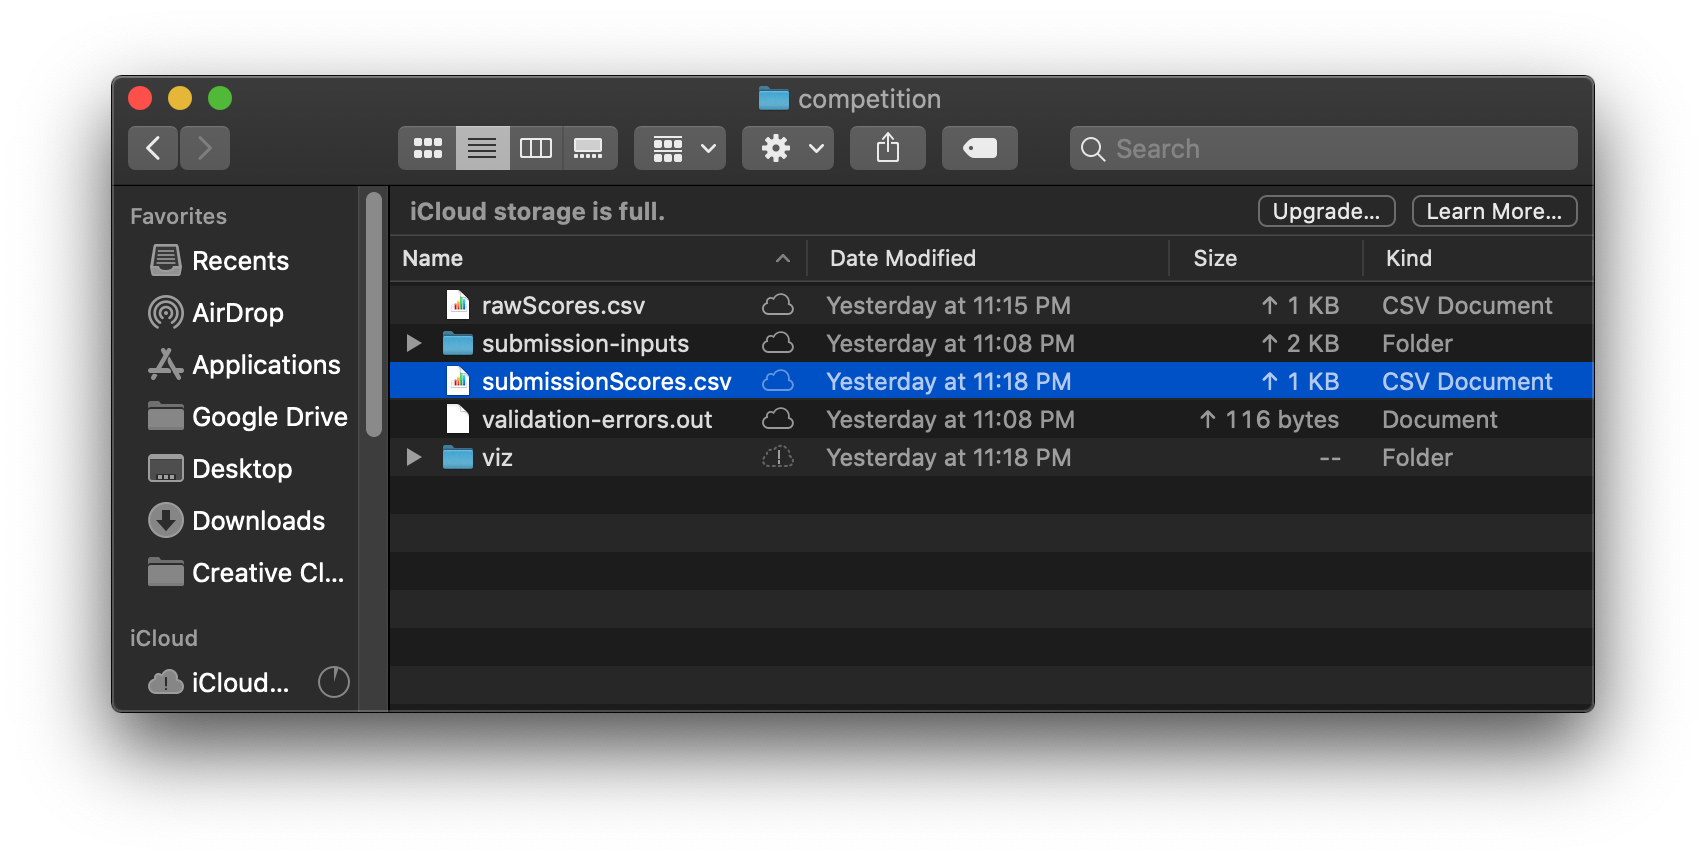

In [21]:
Image(filename = "competition.png", width=900, height=800)

When a simulation run is done, you can import its **results**:

In [22]:
scores, stats = EXECUTOR.get_submission_scores_and_stats(CONTAINER_ID)

/Users/admin/Desktop/BISTRO_Research/BISTRO-Starter-Kit-master/output/sioux_faux/sioux_faux-1k__2020-04-26_05-18-21/competition/submissionScores.csv


In [23]:
scores['Raw Score']

Component Name
Accessibility: number of work locations accessible by car within 15 minutes             1.000000
Accessibility: number of work locations accessible by transit within 15 minutes         1.000000
Accessibility: number of secondary locations accessible by car within 15 minutes        1.000000
Accessibility: number of secondary locations accessible by transit within 15 minutes    1.000000
Level of service: costs and benefits                                                    0.058971
Sustainability: Total grams PM 2.5 Emitted                                              0.000000
Sustainability: Total grams GHGe Emissions                                              0.306875
Congestion: average vehicle delay per passenger trip                                    0.051382
Equity: average travel cost burden - work                                               0.002704
Level of service: average bus crowding experienced                                      5.547350
Equity: average

The **scores** and **statistics** are stored in pandas DataFrames which contains the information described [here](https://github.com/vgolfier/Uber-Prize-Starter-Kit/blob/master/docs/Understanding_the_outputs_and_the%20scoring_function.md).

At the end of any run and to avoid any conflicts between submission ids (particularly if you want to reuse names), it is advised to **clean up containers** calling the following method:

In [24]:
EXECUTOR.stop_all_simulations()

Stopping simulation:
 <Container: 623199e7da>
Done.
Stopping simulation:
 Submission_id: sioux_faux_1k
	 Scenario name: sioux_faux
	 # iters: 1
	 sample size: 1k
Done.


-------

## The `input_sampler` module:<a class="anchor" id="last-bullet">

Randomly sampled data may be used to either initialize the re-planning algorithm or otherwise test the simulation. The `input_sampler` has been provided towards this end. This subsection provides an example of how synthetic random input files may be generated for each of the available input policies to the simulation.

In [23]:
from input_sampler import *
# Specify the common string for the scenario name 
# (currently only "siouxfalls", which refers to the Sioux Falls scenario).
agency = 'sioux_faux_bus_lines'

# Set the paths appropriately
DIR = Path(__name__).absolute().parent.parent
sys.path.append(str(DIR))
DATA_DIR = DIR / 'reference-data/'

agency_dict = scenario_agencies(DATA_DIR,SCENARIO_NAME)
    # Create a lazy cache of GTFS data for the agency:
sf_gtfs_manager = AgencyGtfsDataManager(agency_dict[agency])

# Sample each input five (5) times (naming of functions is indicative of type of input sampled).
freq_df = sample_frequency_adjustment_input(5, sf_gtfs_manager)
mode_incentive_df = sample_mode_incentives_input(5)
vehicle_fleet_mix_df = sample_vehicle_fleet_mix_input(5, sf_gtfs_manager)

# Generated inputs may now be saved in, say, /submission-inputs or some other directory. 
# Remember the location of this directory when executing new simulations.

In [24]:
vehicle_fleet_mix_df

,agencyId,routeId,vehicleTypeId
0,217,1342,BUS-STD-HD
1,217,1341,BUS-DEFAULT
2,217,1340,BUS-STD-HD
3,217,1348,BUS-STD-ART
4,217,1344,BUS-STD-ART


In [25]:
mode_incentive_df

,mode,age,income,amount
0,OnDemand_ride,[26:75],[100000:134999],30.5
1,walk_transit,[51:110],[5000:9999],27.1
2,drive_transit,[36:90],[130000:150000],42.0
3,drive_transit,[91:95],[25000:44999],24.9
4,drive_transit,[6:25],[0:94999],2.6


In [26]:
freq_df

,route_id,start_time,end_time,headway_secs,exact_times
0,1340,21300,67680,720,0
1,1341,3240,66840,5580,0
2,1350,19200,54900,6960,0
3,1351,360,28860,3540,0
4,1351,28860,68520,180,0
5,1343,19080,24600,5700,0
6,1343,24600,38280,300,0
7,1344,58500,71760,240,0
8,1348,2700,21300,6000,0
9,1348,21300,36840,3600,0
